In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

from holotomo.tomo import R
from holotomo.holo import G
from holotomo.magnification import M
from holotomo.shift import S

%matplotlib inline

cp.cuda.Device(0).use()


<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size (scale since 10nm is for 2048)
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# sample size after demagnification
ne = int(np.ceil(n/norm_magnifications[-1]/8))*8 # make multiple of 8

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
# Load a 3D object
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')
delta0 = ndimage.zoom(delta0,n/256,order=1)
beta0 = ndimage.zoom(beta0,n/256,order=1)

# pad with zeros
beta = np.zeros([ne, ne, ne], dtype='float32')
delta = np.zeros([ne, ne, ne], dtype='float32')
delta[ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2] = delta0
beta[ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2,ne//2-delta0.shape[0]//2:ne//2+delta0.shape[0]//2] = beta0

u = delta+1j*beta
u = cp.array(u.astype('complex64'))


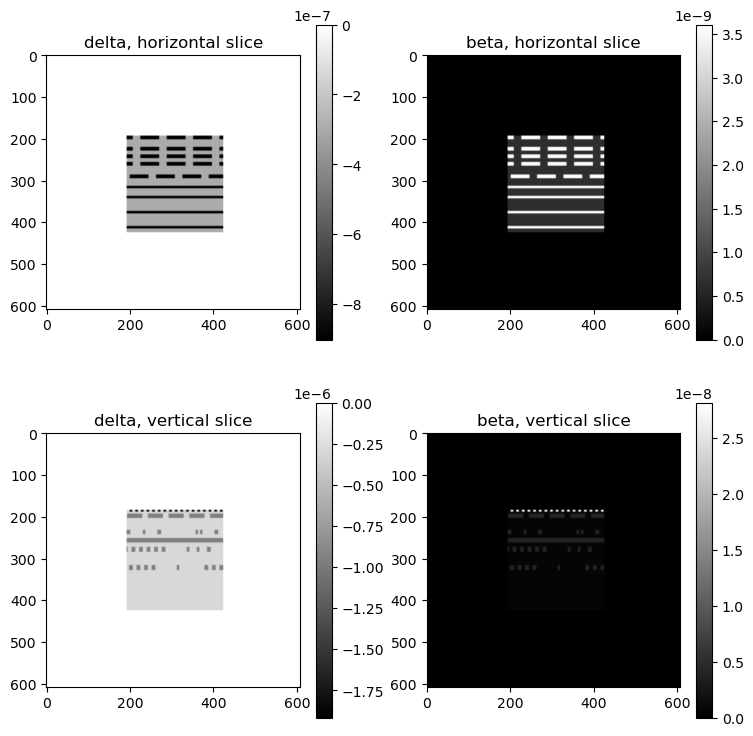

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[ne//2,:,:].real.get(),cmap='gray')
axs[0,0].set_title('delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(u[ne//2,:,:].imag.get(),cmap='gray')
axs[0,1].set_title('beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,ne//2,:].real.get(),cmap='gray')
axs[1,0].set_title('delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,ne//2,:].imag.get(),cmap='gray')
axs[1,1].set_title('beta, vertical slice')
fig.colorbar(im)

Note that in this formation delta is negative

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

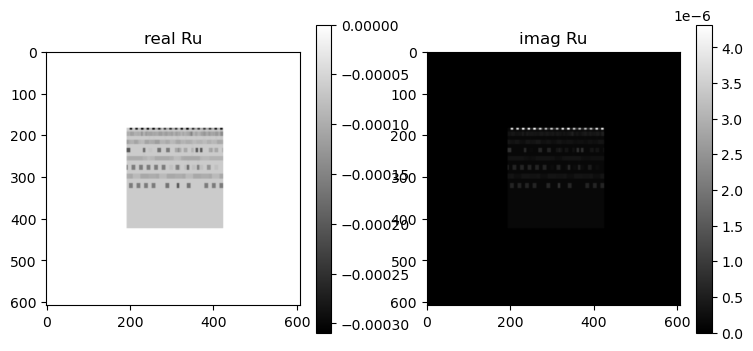

In [5]:
pars = {'theta': theta, 'rotation_axis': center*ne/n}
Ru = R(u,pars)*ne/2 # note, operator R is designed as scaled. 

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(cp.real(Ru[0]).get(),cmap='gray')
axs[0].set_title('real Ru')
fig.colorbar(im)
im=axs[1].imshow(cp.imag(Ru[0]).get(),cmap='gray')
axs[1].set_title('imag Ru')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [6]:
psi = cp.exp(2*cp.pi*1j/wavelength*voxelsize*Ru)

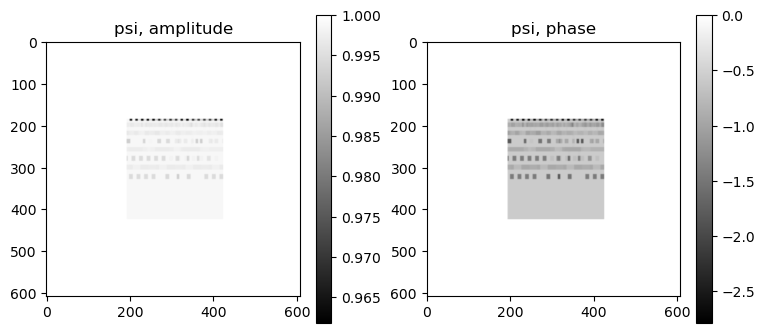

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
axs[0].set_title('psi, amplitude')
fig.colorbar(im)
im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
axs[1].set_title('psi, phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

In [8]:
prb_abs = cp.array(dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[:1])
prb_phase = cp.array(dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[:1])
prb = prb_abs*cp.exp(1j*prb_phase).astype('complex64')  
# prb[:] = 1

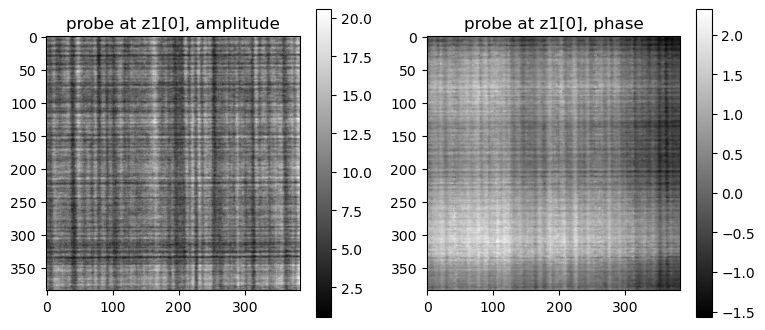

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
axs[0].set_title('probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
axs[1].set_title('probe at z1[0], phase')
fig.colorbar(im)

# Random sample shifts (after magnification)

In [10]:
shifts_sample = (cp.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16
shifts_ref = (cp.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/64 # typically small

# Shifts of the probe (typically small)

In [11]:
shifts_ref0 = (cp.random.random([ndist,1,2]).astype('float32')-0.5)*n/64

# Compute holographic projections for all angles and all distances

In [18]:
def fwd_holo(psi):
    ''' Holography data modeling operator '''

    data = cp.zeros([ndist, ntheta, n, n], dtype='complex64')
    for i in range(ndist):
        prbr = prb.copy()
        psir = psi.copy()
        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref[i]}        
        prbr = S(prb, pars)    
        
        # propagate illumination
        pars = {'wavelength': wavelength, 'z': distances2[i], 'voxelsize': voxelsize}
        prbr = G(prbr, pars)
        
        # object shift for each acquisition
        pars = {'shift': shifts_sample[i]/norm_magnifications[i]}        
        psir = S(psir, pars)            
        
        # scale object        
        if ne != n:
            pars = {'magnification': norm_magnifications[i]*ne/n, 'n': n}
            psir = M(psir, pars)                
        
        # multiply the ill and object
        psir *= prbr            
                
        # propagate both
        pars = {'wavelength': wavelength, 'z': distances[i], 'voxelsize': voxelsize}
        psir = G(psir, pars)   
        data[i] = psir
    return data

def fwd_holo_prb(prb):
    ''' Holography data modeling operator without sample'''

    data = cp.zeros([ndist, n, n], dtype='complex64')
    for i in range(ndist):
        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref0[i]}        
        prbr = S(prb, pars)             
        
        # propagate illumination 
        pars = {'wavelength': wavelength, 'z': distances[0], 'voxelsize': voxelsize}

        data[i] = G(prbr, pars)
    return data

fpsi = fwd_holo(psi)
fref = fwd_holo_prb(prb)

## Take squared absolute value to simulate data on the detector and a reference image

In [13]:
data = cp.abs(fpsi)**2
ref = cp.abs(fref)**2

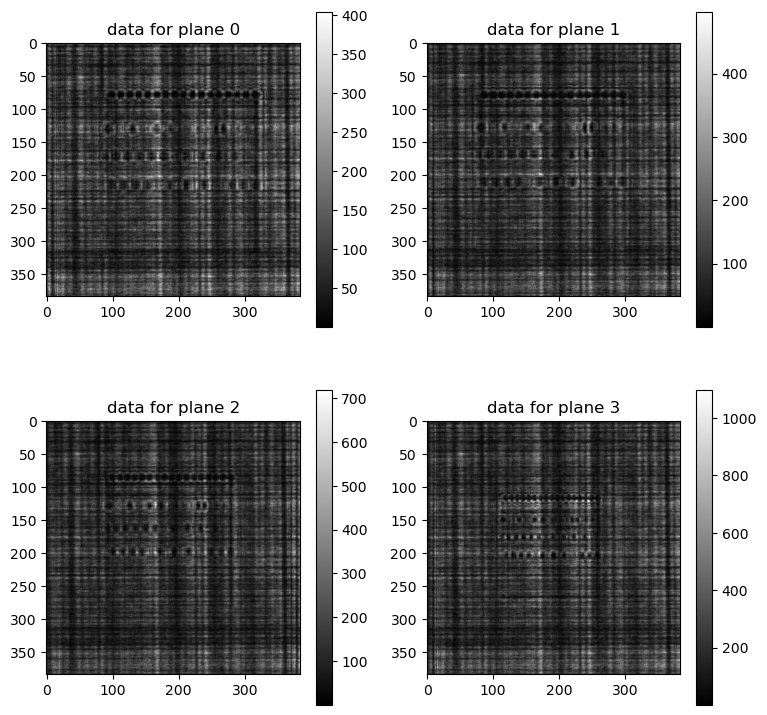

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0].get(),cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0].get(),cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0].get(),cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0].get(),cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)

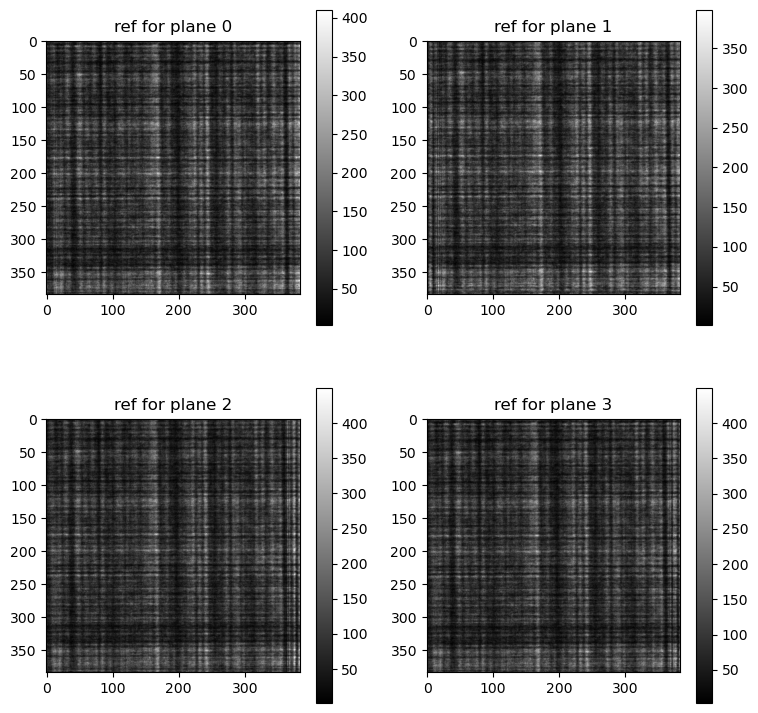

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref[0].get(),cmap='gray')
axs[0,0].set_title('ref for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref[1].get(),cmap='gray')
axs[0,1].set_title('ref for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(ref[2].get(),cmap='gray')
axs[1,0].set_title('ref for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(ref[3].get(),cmap='gray')
axs[1,1].set_title('ref for plane 3')
fig.colorbar(im)

# Save data, reference images, and shifts

In [16]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k].get(),f'data/modeling/data_chip_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[k,0].get(),f'data/modeling/ref_chip_{n}_{k}',overwrite=True)
np.save('shifts_sample',shifts_sample.get())
np.save('shifts_ref',shifts_ref.get())
np.save('shifts_ref0',shifts_ref0.get())